<a href="https://colab.research.google.com/github/nurafnilm/lautify-ml/blob/main/model/Lautify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report

Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
csv_path = '/content/drive/MyDrive/datasetCapstone/dataset/dataset/train/_annotations.csv'
train_df = pd.read_csv(csv_path)

csv_path = '/content/drive/MyDrive/datasetCapstone/dataset/dataset/valid/_annotations.csv'
valid_df = pd.read_csv(csv_path)

csv_path = '/content/drive/MyDrive/datasetCapstone/dataset/dataset/test/_annotations.csv'
test_df = pd.read_csv(csv_path)

print(train_df.head())
print(valid_df.head())
print(test_df.head())


                                            filename  width  height  class  \
0  IMG_20230308_064629_jpg.rf.00aa7a9f866ac5b5221...    640     640      0   
1  IMG_20230312_093250_jpg.rf.008e4f92dd49b8699ad...    640     640      1   
2  IMG_20230309_064729_jpg.rf.00b040be83393c86b9a...    640     640      0   
3  IMG_20230309_064729_jpg.rf.00b040be83393c86b9a...    640     640      0   
4  IMG_20230309_064729_jpg.rf.00b040be83393c86b9a...    640     640      1   

   xmin  ymin  xmax  ymax  
0   259   288   332   350  
1   249   316   458   484  
2    34   329   139   420  
3   455   229   557   314  
4   337   416   452   530  
                                            filename  width  height  class  \
0  IMG_20230309_071227_jpg.rf.7f050efd27fffc97e31...    640     640      1   
1  IMG_20230309_071227_jpg.rf.7f2a36d808fa2e6bae9...    640     640      1   
2  IMG_20230308_161413_jpg.rf.7ff21cf8e5ce925a616...    640     640      1   
3  IMG_20230308_161413_jpg.rf.7ff21cf8e5ce925a616..

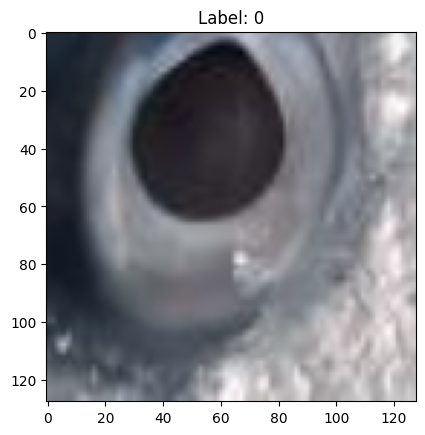

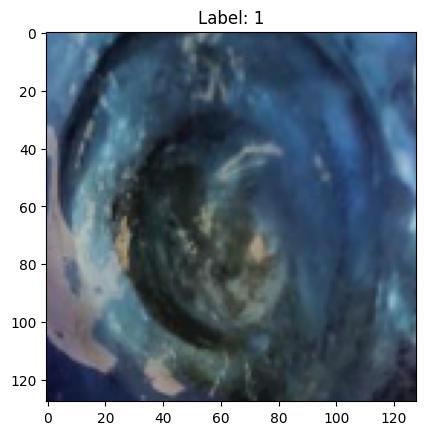

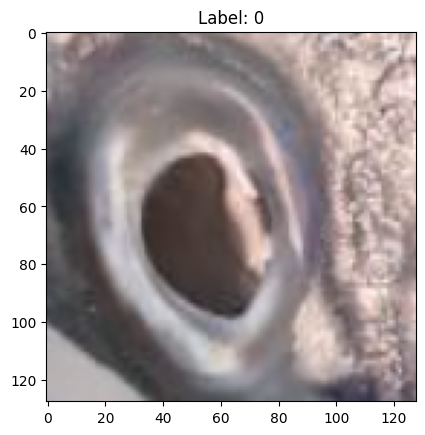

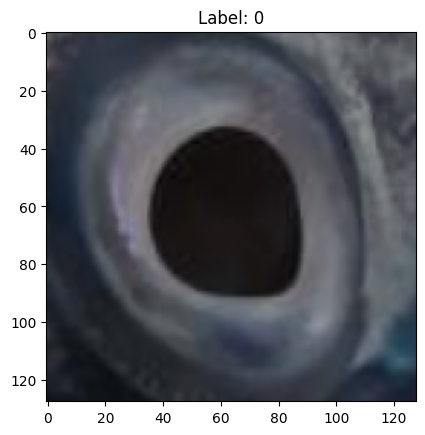

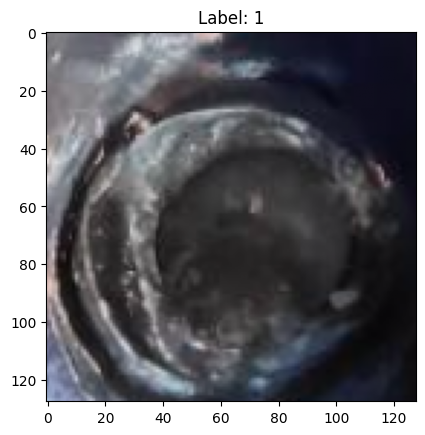

In [ ]:
def load_images_and_labels(df, image_folder):
    images = []
    labels = []

    for index, row in df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        img = cv2.imread(img_path)

        if img is not None:
            # Ambil bounding box dari CSV
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            class_id = row['class']

            # Crop dan resize gambar sesuai bounding box
            cropped_img = img[ymin:ymax, xmin:xmax]
            resized_img = cv2.resize(cropped_img, (128, 128))

            images.append(resized_img)
            labels.append(class_id)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Path ke folder yang berisi gambar
train_images_path = '/content/drive/MyDrive/datasetCapstone/dataset/dataset/train/'
valid_images_path = '/content/drive/MyDrive/datasetCapstone/dataset/dataset/valid/'
test_images_path = '/content/drive/MyDrive/datasetCapstone/dataset/dataset/test/'

train_images, train_labels = load_images_and_labels(train_df, train_images_path)
valid_images, valid_labels = load_images_and_labels(valid_df, valid_images_path)
test_images, test_labels = load_images_and_labels(test_df, test_images_path)

# Normalize images
train_images = train_images / 255.0
valid_images = valid_images / 255.0
test_images = test_images / 255.0

# Konversi label ke bentuk one-hot encoding
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)
test_labels = to_categorical(test_labels)

# Tampilkan beberapa gambar dan label
for i in range(5):
    plt.imshow(train_images[i])
    plt.title(f'Label: {np.argmax(train_labels[i])}')
    plt.show()


In [ ]:
# Print jumlah gambar yang terbaca
print(f'Number of training images: {len(train_images)}')
print(f'Number of validation images: {len(valid_images)}')
print(f'Number of test images: {len(test_images)}')

# Print jumlah label yang terbaca
print(f'Number of training labels: {len(train_labels)}')
print(f'Number of validation labels: {len(valid_labels)}')
print(f'Number of test labels: {len(test_labels)}')

Number of training images: 1885
Number of validation images: 482
Number of test images: 261
Number of training labels: 1885
Number of validation labels: 482
Number of test labels: 261


Preprocessing

In [ ]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [ ]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Modelling

In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape = (128, 128, 3)
num_classes = train_labels.shape[1]
model = create_cnn_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit(train_images, train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(valid_images, valid_labels))


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')


In [ ]:
# Generate classification report
test_predictions = model.predict(test_images)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, test_predictions_labels, target_names=['Fresh', 'Not Fresh']))

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/datasetCapstone/fish_freshness_model.h5')